In [1]:
import gdsfactory as gf
import meep as mp
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Using MPI version 4.1, 1 processes


PosixPath('/home/reema/Desktop/PIC/grating_coupler.gds')

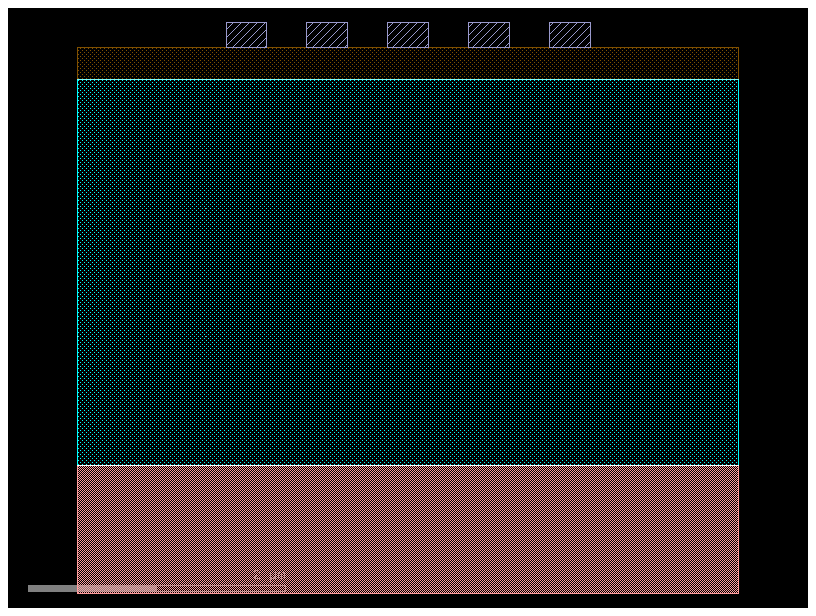

In [2]:
def waveguide(l, w, ly):
  xs = gf.cross_section.strip(width = w, layer = [ly, 0])
  return gf.components.straight(length = l, cross_section=xs)

def waveguide_antenna():

  c = gf.Component()

  l = period * n_periods+2
  
  l0 = c << waveguide(l, w0, 1)
  l0.move((0, w0/2))
  l1 = c << waveguide(l, w1, 2)
  l1.move((0,w0+w1/2))
  l2 = c << waveguide(l, w2, 3)
  l2.move((0, w0+ w1 + w2/2))

  for i in range(n_periods):
        tooth = c << waveguide(
        l = period * duty_cycle,
        w=grating_height,
        ly=4
        )
        x_position = c.xsize/2 -l/2 + 1 + i * period + (period * (1 - duty_cycle) / 2)
        tooth.move(( x_position, w0+w1+w2+grating_height/2))
  return c

w0 = 1  #substrate
w1 = 3  # sio2
w2 = 0.25  #si waeguide  500 nm = 0.5
n_periods, period, duty_cycle, grating_height = 5, 0.63, 0.5, 0.2

c = gf.Component()

c = waveguide_antenna()
c.flatten()
c.plot()

gdsII_file= "/home/reema/Desktop/PIC/grating_coupler.gds"

c.write_gds(gdsII_file)




-----------
Initializing structure...
time for choose_chunkdivision = 0.00100773 s
Working in 2D dimensions.
Computational cell is 7.15 x 9.95 x 0 with resolution 60
     prism, center = (-1.2595,0.35,0)
          height 1, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-1.417,0.25,-0.5)
          (-1.417,0.45,-0.5)
          (-1.102,0.45,-0.5)
          (-1.102,0.25,-0.5)
          dielectric constant epsilon diagonal = (4,4,4)
     prism, center = (-0.6305,0.35,0)
          height 1, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.788,0.25,-0.5)
          (-0.788,0.45,-0.5)
          (-0.473,0.45,-0.5)
          (-0.473,0.25,-0.5)
          dielectric constant epsilon diagonal = (4,4,4)
     prism, center = (0.0005,0.35,0)
          height 1, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-0.157,0.25,-0.5)
          (-0.157,0.45,-0.5)
          (0.158,0.45,-0.5)
          (0.158,0.25,-0.5)
          dielectric constant epsilon diag

     prism, center = (0.6305,0.35,0)
          height 1, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (0.473,0.25,-0.5)
          (0.473,0.45,-0.5)
          (0.788,0.45,-0.5)
          (0.788,0.25,-0.5)
          dielectric constant epsilon diagonal = (4,4,4)
     prism, center = (1.2605,0.35,0)
          height 1, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (1.103,0.25,-0.5)
          (1.103,0.45,-0.5)
          (1.418,0.45,-0.5)
          (1.418,0.25,-0.5)
          dielectric constant epsilon diagonal = (4,4,4)
     prism, center = (0,0.125,0)
          height 0.45, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.575,0,-0.225)
          (-2.575,0.25,-0.225)
          (2.575,0.25,-0.225)
          (2.575,0,-0.225)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
     prism, center = (0,-1.5,0)
          height 3, axis (0,0,1), sidewall angle: 0 radians, 4 vertices:
          (-2.575,-3,-1.5)
          (-2.57

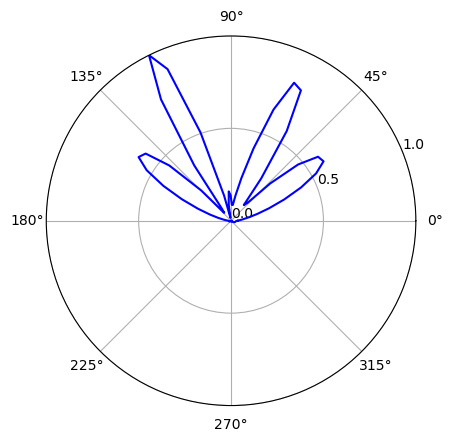

In [20]:
def plot_radiation_pattern_3d(Ptheta):
    """Plots the radiation pattern in 3d Cartesian coordinates.

    Args:
        Ptheta: radial flux of the far fields in polar coordinates.
    """

    xs = np.zeros((len(thetas), len(phis)))
    ys = np.zeros((len(thetas), len(phis)))
    zs = np.zeros((len(thetas), len(phis)))

    for i, theta in enumerate(thetas):
        for j, phi in enumerate(phis):
            xs[i, j] = Ptheta[i] * np.sin(theta) * np.cos(phi)
            ys[i, j] = Ptheta[i] * np.sin(theta) * np.sin(phi)
            zs[i, j] = Ptheta[i] * np.cos(theta)

    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    c = ax.pcolor(
        phis, thetas, xs/np.max(xs), shading="auto", cmap="hot", vmin=0, vmax=1
    )
    cb = fig.colorbar(c, ax=ax)
    cb.set_label("Intensity")
    _ = plt.setp(ax.get_yticklabels(), color="white")

    # plot the radiation pattern in polar coordinates
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    c = ax.pcolor(
        phis, np.rad2deg(thetas), ys/np.max(ys), shading="auto", cmap="hot", vmin=0, vmax=1
    )
    cb = fig.colorbar(c, ax=ax)
    cb.set_label("Intensity")
    _ = plt.setp(ax.get_yticklabels(), color="white")

    # plot the radiation pattern in polar coordinates
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    c = ax.pcolor(
        phis, thetas, zs/np.max(zs), shading="auto", cmap="hot", vmin=0, vmax=1
    )
    cb = fig.colorbar(c, ax=ax)
    cb.set_label("Intensity")
    _ = plt.setp(ax.get_yticklabels(), color="white")

    
def simulation(sim):
    nearfield = sim.add_near2far(fcen, 0, 1, mp.Near2FarRegion(mp.Vector3(0,0.5*sy-dpml-2.5*dair,0), size=mp.Vector3(sx-2*dpml, 0, sz-2*dpml)))

    sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, mp.Vector3(), 1e-3))
    
    angles = phis

    E = np.zeros((npts,3),dtype=np.complex128)
    H = np.zeros((npts,3),dtype=np.complex128)
    for n in range(npts):
        ff = sim.get_farfield(nearfield,
                          mp.Vector3(r*math.cos(angles[n]),
                                     r*math.sin(angles[n]),0))
        E[n,:] = [ff[j] for j in range(3)]
        H[n,:] = [ff[j+3] for j in range(3)]
    
    Px = np.real(np.conj(E[:, 1]) * H[:, 2] - np.conj(E[:, 2]) * H[:, 1])
    Py = np.real(np.conj(E[:, 2]) * H[:, 0] - np.conj(E[:, 0]) * H[:, 2])
    # Pz = np.real(np.conj(E[:, 0]) * H[:, 1] - np.conj(E[:, 1]) * H[:, 0])
    Pr = np.sqrt(np.square(Px) + np.square(Py))


    ax = plt.subplot(111, projection='polar')
    ax.plot(angles,Pr/max(Pr),'b-')
    ax.set_rmax(1)
    ax.set_rticks([0,0.5,1])
    ax.grid(True)
    ax.set_rlabel_position(22)
    plt.show()
    
    return Pr
    
def design():
    #import gdsfile as geometry
    geometry = (
        mp.get_GDSII_prisms(si3n4, gdsII_file, 4, -t_si3n4/2, t_si3n4/2)+
        mp.get_GDSII_prisms(si, gdsII_file, 3, -t_si/2, t_si/2) +
        mp.get_GDSII_prisms(sio2, gdsII_file, 2, -t_sio2/2, t_sio2/2) +
        mp.get_GDSII_prisms(si, gdsII_file, 1, -t_sub/2, t_sub/2)
    
    )
    
    for g in geometry:
        g.center -= mp.Vector3(l_g/2, (w0+w1), 0)
        
    #define the source
    #size = (0, waveguide width, 0)
    sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen, fwidth=0.2*fcen),
                                size=mp.Vector3(0,0.25,0),
                                center=mp.Vector3(-0.5*sx + dpml,w2/2,0),
                                eig_match_freq=True,
                                eig_parity=mp.ODD_Y)]

    # Use PML boundary layers on all sides
    pml_layers = [mp.PML(dpml)]
    
    # Create simulation object
    sim = mp.Simulation(
        cell_size=cell,
        boundary_layers=pml_layers,
        geometry=geometry,
        sources=sources,
        resolution=resolution,
        dimensions=2
    )
    #to visualize the setup
    # sim.plot2D(fields=mp.Ex, output_plane=mp.Volume(center=mp.Vector3(0, 0, 0), size=mp.Vector3(sx, sy, 0)))
    return sim


dpml = 1.0
dair = 1
l_g = c.xsize   #length of grating
w = c.ysize   #width of the total grating

t_si3n4 = 1
t_si = 0.45
t_sio2 = 3*(t_si3n4)
t_sub = t_sio2


sx, sy, sz = l_g + 2 * dpml, w + 2 * dpml + 3.5 * dair, t_sub + 2 * dpml
cell = mp.Vector3(sx, sy, 0)
resolution = 60


si = mp.Medium(index=3.6)
sio2 = mp.Medium(index=1.44)
si3n4 = mp.Medium(index=2.0)

wvl = 1.55
fcen = 1 / wvl
width = 0.1
fwidth = width * fcen

src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)

r = 1000/fcen  # 1000 wavelengths out from the source
npts = 100  # number of points in [0,2*pi) range of angles
# define field projection angle ranges
thetas = np.linspace(0, np.pi/3, npts)  # polar angle
phis = np.linspace(0, 2 * np.pi, npts)  # azimuthal angle

sim = design()
Pr = simulation(sim)



In [18]:
idx = np.where((phis > np.deg2rad(45)) & (phis < np.deg2rad(70)))
sPr = Pr[idx]
far_flux_circle = (np.sum(sPr)/np.max(sPr))/(np.sum(Pr)/np.max(Pr))
far_flux_circle

0.2656544132901688

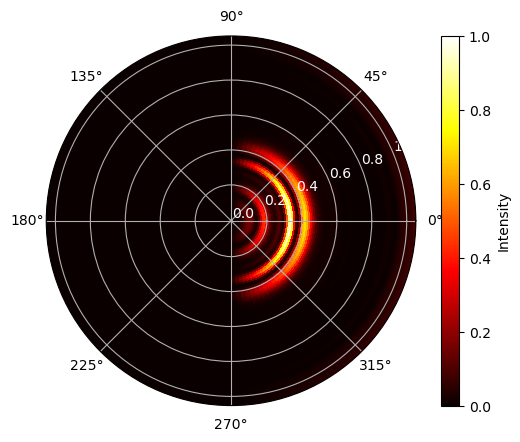

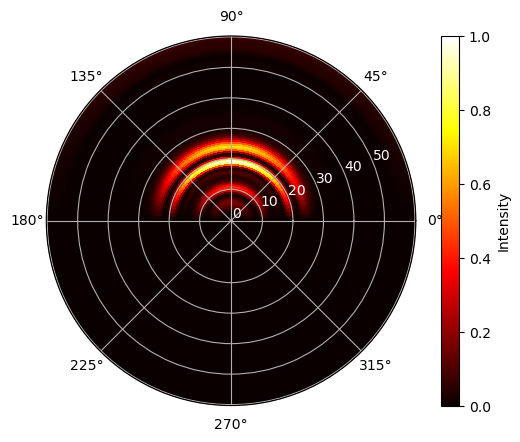

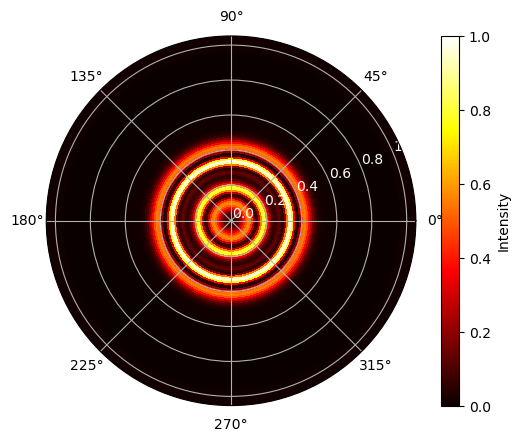

In [19]:
plot_radiation_pattern_3d(r**2*Pr)